# Chapter 11 - I2VIS - Clean version

This is an implementation of a 2D viscous flow code. The energy equation (for temperature) is solved at the cell centers (unlike the example in the chapter 10 notebook, which is solved at the basic nodes.

This notebook puts all of the major function definitions into separate source files and contains only the high-level program code.

In [1]:
# Import necessary packages
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using WriteVTK
using Printf
using Statistics 
include("Grid.jl")
include("GridOperations.jl")
include("Markers.jl")
include("Stokes.jl")
include("Temperature.jl")

# note that we import pyplot last to avoid a name conflict with grid.
using PyPlot
include("Visualization.jl")

plots (generic function with 1 method)

# Problem setup

100 km sticky air layer, 500x500 km box
We define the materials used in this computation here.
We introduce functions that compute the density on the markers.
We introduce a function that computes the initial conditions (on the markers).

In [2]:
struct Materials
    # 1 - mantle
    # 2 - plume
    # 3 - sticky air
    alpha::Vector{Float64}
    rho0::Vector{Float64}
    Hr::Vector{Float64}
    Cp::Vector{Float64}
    kThermal::Vector{Float64}
    eta::Vector{Float64}
    function Materials()
         # These are the values used in Gerya's problem 11.1
         new([3e-5,2e-5,0.0],[3300.,3200.,1.0],[2e-8,3e-8,0.0],[1000.,1000.,3.3e6],[3.0,2.0,300.0],[1e21,1e20,1e17])
    end
end

function update_marker_density!(markers::Markers,materials::Materials)
    rho = markers.scalarFields["rho"]
    T = markers.scalarFields["T"]
    mmat = markers.integers[markers.integerFields["material"],:]
    
    for i in 1:markers.nmark                
        # receompute density using the current temperature value
        # assume reference temperature is 273.0
        markers.scalars[rho,i] = materials.rho0[mmat[i]] # don't update density - for comparison with gerya
        # materials.rho0[mmat[i]]*(1.0-materials.alpha[mmat[i]]*(markers.scalars[T,i]-273.0)) 
    end
end

function initial_conditions!(markers::Markers,materials::Materials)
    material = markers.integerFields["material"]
    T = markers.scalarFields["T"]
    eta = markers.scalarFields["eta"]
    alpha = markers.scalarFields["alpha"]
    cp = markers.scalarFields["Cp"]
    Hr = markers.scalarFields["Hr"]
    for i in 1:markers.nmark
        mx = markers.x[1,i]
        my = markers.x[2,i]
        mr = ((mx-2.5e5)^2 + (my-2.5e5)^2)^0.5
        if my < 1e5
             # sticky air
             markers.integers[material,i] = 3
             markers.scalars[T,i] = 273.0
             markers.scalars[eta,i] = materials.eta[3]
             markers.scalars[alpha,i] = materials.alpha[3]  
             markers.scalars[cp,i] = materials.Cp[3]  
             markers.scalars[Hr,i] = materials.Hr[3]  
         elseif mr < 1e5
             # plume
             markers.integers[material,i] = 2
             markers.scalars[T,i] = 1800.0
             markers.scalars[eta,i] = materials.eta[2]
             markers.scalars[alpha,i] = materials.alpha[2]            
             markers.scalars[cp,i] = materials.Cp[2]  
             markers.scalars[Hr,i] = materials.Hr[2]  
         else
            # ambient mantle
            markers.integers[material,i] = 1
            markers.scalars[T,i] = 1500.0            
            markers.scalars[eta,i] = materials.eta[1]
            markers.scalars[alpha,i] = materials.alpha[1]            
            markers.scalars[cp,i] = materials.Cp[1]
            markers.scalars[Hr,i] = materials.Hr[1]  
         end
    end
    update_marker_density!(markers,materials)
end

initial_conditions! (generic function with 1 method)

# i2vis procedure

0. Set up the Eulerian grid and Lagrangian markers. Distribute the markers within the domain and assign initial conditions.
1. Compute density and viscosity at the basic nodes. Compute cell center viscosity via averaging.
2. Assemble and solve the Stokes equations.
3. Compute the maximum timestep from the velocity field and CFL number.
3. Transfer temperature from markers to basic nodes.
4. Compute the new temperature solution.
5. If the maximum temperature change exceeds a specified value, reduce the timstep and repeat previous step.
6. Compute the subgrid temperature changes and update the temperature on the markers.
7. Move the markers using 4th order Runge-Kutta

TO DO:
1. Calculate rhox (rho at vx points) -> (optionally) pass to Stokes.jl (Max)
3. Add free-surface stabilization terms to Stokes.jl (Lucy)
4. Add functionality for shear heating (Max)
5. Add functionality for adiabatic heating (Uthkarsh)

In [12]:
function run(nstep::Int64)
    nx = 101
    ny = 101
    W = 5e5
    H = 5e5
    gx = 0.0
    gy = 10.0

    Tbcval = [0.0,0.0,273.0,1500.0]
    bc = BoundaryConditions(0,0,0,0) # currently does nothing but is required argument to stokes solver.
    materials = Materials()
    
    markx = 6
    marky = 6
    seconds_in_year = 3.15e7
    plot_interval = 1e6*seconds_in_year # plot interval in seconds
    end_time = 3e7*seconds_in_year
    dtmax = plot_interval
    grid = CartesianGrid(W,H,nx,ny)
    println("Creating Markers...")
    @time markers = Markers(grid,["alpha","Cp","T","rho","eta","Hr"],["material"] ; nmx=markx,nmy=marky,random=true)
    println("Initial condition...")
    @time initial_conditions!(markers, materials)

    # define arrays for k, rho, cp, H at the basic nodes. Fill them with constant values for now.
    kThermal = 3.0 .*ones(grid.ny,grid.nx);

    time = 0.0
    iout=0
    last_plot = 0.0
    rho_c = nothing
    dt = 1e10

      local rho_c
      local rho_vx
      local rho_vy
      local alpha
      local Hr
      local Cp_c
      local eta_s
      local eta_n
      local vxc
      local vyc
      local T
      local dt
      local dTmax
      local dTemp
      local Tnew
      local Tlast

    output_dir = "test"
    for itime in 1:nstep
        # 1. Transfer properties markers -> nodes
        # 1a. Basic Nodes
        eta_s_new, = marker_to_basic_node(markers,grid,["eta",]);
        # 1b. Cell Centers
        rho_c_new,Cp_c_new,alpha_new,eta_n_new,Tlast_new,Hr_new = marker_to_cell_center(markers,grid,["rho","Cp","alpha","eta","T","Hr"])
        # 1c. Vx and Vy nodes:
        rho_vx_new, = marker_to_stag(markers,grid,["rho",],"vx")
        rho_vy_new, = marker_to_stag(markers,grid,["rho",],"vy")
        
        # deal with any NaN values from interpolation:
        if itime > 1
            if any(isnan.(eta_s_new))
                println("found nan values")
            end
            replace_nan!(eta_s,eta_s_new)
            replace_nan!(rho_c,rho_c_new)
            replace_nan!(Hr,Hr_new)
            replace_nan!(Cp_c,Cp_c_new)
            replace_nan!(alpha,alpha_new)
            replace_nan!(eta_n,eta_n_new)
            replace_nan!(Tlast,Tlast_new)
            replace_nan!(rho_vx,rho_vx_new)
            replace_nan!(rho_vy,rho_vy_new)
        end
        # Copy field data 
        rho_vx = copy(rho_vx_new)
        rho_vy = copy(rho_vy_new)
        rho_c = copy(rho_c_new)
        Hr = copy(Hr_new)
        Cp_c = copy(Cp_c_new)
        alpha = copy(alpha_new)
        eta_s = copy(eta_s_new)
        eta_n = copy(eta_n_new)
        Tlast = copy(Tlast_new)
    
        # 2. Assemble and solve the stokes equations
        L,R = form_stokes(grid,eta_s,eta_n,rho_vx,rho_vy,bc,gx,gy,dt)
        stokes_solution = L\R
        vx,vy,P = unpack(stokes_solution,grid;ghost=true)
    
        # Get the velocity at the cell centers:
        vxc,vyc = velocity_to_centers(grid,vx,vy)
        adiabatic_heating = compute_adiabatic_heating(grid,rho_c,Tlast,alpha,gx,gy,vxc,vyc)
        shear_heating = compute_shear_heating(grid,vx,vy,eta_n,eta_s)
        H = (adiabatic_heating .+ shear_heating .+ Hr)
    
        # 3. Compute the advection timestep:
        if itime > 1
            this_dtmax = min(1.2*dt,dtmax)
        else
            this_dtmax = dtmax
        end
        dt = compute_timestep(grid,vxc,vyc ; dtmax=this_dtmax)
        
        dTmax = Inf
        dTemp = nothing
        Tnew = nothing
        titer=1
        for titer=1:2# limit maximum temperature change
            # assemble and solve the energy equation
            println("Trying with timestep ",dt/3.15e7/1e6," Myr")
            L,R = assemble_energy_equation_center(grid,rho_c,Cp_c,kThermal,H,Tlast,dt,Tbcval);
            Tnew = L\R;
            Tnew = reshape(Tnew,grid.ny,grid.nx);
            Tnew = ghost_temperature_center(grid,Tnew,Tbcval);

            T = copy(Tnew)

            dTemp = Tnew-Tlast
            # compute the maximum temperature change
            dTmax = maximum(abs.(dTemp))
            println("dTmax=",dTmax," dt=",dt/3.15e7/1e6)
            dt = min(dt,dTmax < 10.0 ? dt : dt*10.0/dTmax)
            if dTmax < 10.0
                break
            end
        end

        dT_subgrid_node = subgrid_temperature_relaxation_center!(markers,grid,Tlast,Cp_c[1,1],kThermal[1,1],dt)
        dT_remaining = dTemp - dT_subgrid_node

        cell_center_change_to_markers!(markers,grid,dT_remaining,"T")

        if time == 0.0 || time - last_plot >= plot_interval
            last_plot = time 
            name = @sprintf("%s/viz.%04d.vtr",output_dir,iout)
            println("Writing visualization fle ",name)
            vn = velocity_to_basic_nodes(grid,vxc,vyc)

        visualization(grid,rho_c,eta_s,vn,P,Tnew[2:end-1,2:end-1],time/seconds_in_year;filename=name)
            name = @sprintf("%s/markers.%04d.vtp",output_dir,iout)
            visualization(markers,time/seconds_in_year;filename=name)
            iout += 1
        end
        
        println("Min/Max velocity: ",minimum(vyc)," ",maximum(vyc))
        move_markers_rk4!(markers,grid,vx,vy,dt,continuity_weight=1/3)
        time += dt
        println("Finished Step ",itime," time=",time/seconds_in_year/1e6," Myr")
    end
    return grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time
end
@time grid,markers,vxc,vyc,rho_c,eta_n,Tnew,time = run(250)


Creating Markers...
  0.004565 seconds (19 allocations: 28.154 MiB)
Initial condition...
  0.084860 seconds (1.08 M allocations: 17.151 MiB, 11.45% gc time)
Trying with timestep 0.02074889134401459 Myr
dTmax=17.558482569569776 dt=0.02074889134401459
Trying with timestep 0.011817018504761932 Myr
dTmax=17.535886453042508 dt=0.011817018504761932
Writing visualization fle test/viz.0000.vtr
Min/Max velocity: -3.825027470104986e-9 2.219791102203775e-9
Finished Step 1 time=0.006738763128060549 Myr
Trying with timestep 0.006952396700995503 Myr
dTmax=10.905105040813964 dt=0.006952396700995503
Trying with timestep 0.006375359682437842 Myr
dTmax=10.903220900449753 dt=0.006375359682437842
Min/Max velocity: -1.003749573979328e-8 1.1415499255632982e-8
Finished Step 2 time=0.012585989136454877 Myr
Trying with timestep 0.0012924262621453475 Myr
dTmax=11.5275726647983 dt=0.0012924262621453475
Trying with timestep 0.0011211608026484396 Myr
dTmax=11.526934481769842 dt=0.0011211608026484396
Min/Max veloci

dTmax=29.301381725448437 dt=2.5145792675309472e-6
Trying with timestep 8.581777102159721e-7 Myr
dTmax=10.000061530194841 dt=8.581777102159721e-7
Min/Max velocity: -5.5807737597363226e-6 3.4825842981974158e-6
Finished Step 42 time=0.03373299800716671 Myr
Trying with timestep 1.0298069158371484e-6 Myr
dTmax=28.329049942544543 dt=1.0298069158371484e-6
Trying with timestep 3.6351622024944264e-7 Myr
dTmax=10.000024749291356 dt=3.6351622024944264e-7
Min/Max velocity: -8.573648418340052e-6 5.3948636149003445e-6
Finished Step 43 time=0.033733361522487286 Myr
Trying with timestep 4.362183846897414e-7 Myr
dTmax=25.712523536587696 dt=4.362183846897414e-7
Trying with timestep 1.6965210904679326e-7 Myr
dTmax=10.000009900785528 dt=1.6965210904679326e-7
Min/Max velocity: -1.2548664218589146e-5 7.928575786957961e-6
Finished Step 44 time=0.03373353117442836 Myr
Trying with timestep 2.0358232929365394e-7 Myr
dTmax=27.45314233715436 dt=2.0358232929365394e-7
Trying with timestep 7.415629394749867e-8 Myr
d

Finished Step 76 time=0.03373365558000165 Myr
Trying with timestep 7.56968548870647e-24 Myr
dTmax=40.37422265586747 dt=7.56968548870647e-24
Trying with timestep 1.874880800362949e-24 Myr
dTmax=10.0 dt=1.874880800362949e-24
Min/Max velocity: -3773.5614586140678 2399.941675997977
Finished Step 77 time=0.03373365558000165 Myr
Trying with timestep 2.2498569604355385e-24 Myr
dTmax=40.6711680438533 dt=2.2498569604355385e-24
Trying with timestep 5.531822833338968e-25 Myr
dTmax=10.000000000000114 dt=5.531822833338968e-25
Min/Max velocity: -6947.109226285007 4418.281547258897
Finished Step 78 time=0.03373365558000165 Myr
Trying with timestep 6.638187400006687e-25 Myr
dTmax=39.64843384932078 dt=6.638187400006687e-25
Trying with timestep 1.6742621979053037e-25 Myr
dTmax=9.999999999999886 dt=1.6742621979053037e-25
Min/Max velocity: -12627.765913818468 8031.113849388696
Finished Step 79 time=0.03373365558000165 Myr
Trying with timestep 2.0091146374863645e-25 Myr
dTmax=40.64794029915436 dt=2.0091146

Min/Max velocity: -1.232506191597041e6 783859.7589162088
Finished Step 121 time=0.03373365558000165 Myr
Trying with timestep 8.5434738116752e-31 Myr
dTmax=9.457290697486033e7 dt=8.5434738116752e-31
Trying with timestep 9.033743473642249e-38 Myr
dTmax=10.0 dt=9.033743473642249e-38
Min/Max velocity: -1.0933359827333656e10 1.719112829669757e10
Finished Step 122 time=0.03373365558000165 Myr
Trying with timestep 1.0840492168370697e-37 Myr
dTmax=11.999999999999886 dt=1.0840492168370697e-37
Trying with timestep 9.033743473642335e-38 Myr
dTmax=10.000000000000114 dt=9.033743473642335e-38
Min/Max velocity: -1.0933359827333656e10 1.719112829669757e10
Finished Step 123 time=0.03373365558000165 Myr
Trying with timestep 1.084049216837068e-37 Myr
dTmax=12.000000000000114 dt=1.084049216837068e-37
Trying with timestep 9.033743473642148e-38 Myr
dTmax=10.0 dt=9.033743473642148e-38
Min/Max velocity: -1.0933359827333656e10 1.719112829669757e10
Finished Step 124 time=0.03373365558000165 Myr
Trying with time

Finished Step 156 time=0.03373365558000165 Myr
Trying with timestep 1.0840492168370532e-37 Myr
dTmax=11.999999999999886 dt=1.0840492168370532e-37
Trying with timestep 9.033743473642195e-38 Myr
dTmax=10.000000000000114 dt=9.033743473642195e-38
Min/Max velocity: -1.0933359827333656e10 1.719112829669757e10
Finished Step 157 time=0.03373365558000165 Myr
Trying with timestep 1.084049216837051e-37 Myr
dTmax=11.999999999999773 dt=1.084049216837051e-37
Trying with timestep 9.033743473642265e-38 Myr
dTmax=10.000000000000114 dt=9.033743473642265e-38
Min/Max velocity: -1.0933359827333656e10 1.719112829669757e10
Finished Step 158 time=0.03373365558000165 Myr
Trying with timestep 1.0840492168370592e-37 Myr
dTmax=11.999999999999886 dt=1.0840492168370592e-37
Trying with timestep 9.033743473642246e-38 Myr
dTmax=10.0 dt=9.033743473642246e-38
Min/Max velocity: -1.0933359827333656e10 1.719112829669757e10
Finished Step 159 time=0.03373365558000165 Myr
Trying with timestep 1.0840492168370693e-37 Myr
dTmax=

dTmax=11.999999999999886 dt=1.0840492168370505e-37
Trying with timestep 9.033743473642174e-38 Myr
dTmax=9.999999999999886 dt=9.033743473642174e-38
Min/Max velocity: -1.0933359827333656e10 1.719112829669757e10
Finished Step 192 time=0.03373365558000165 Myr
Trying with timestep 1.0840492168370607e-37 Myr
dTmax=12.0 dt=1.0840492168370607e-37
Trying with timestep 9.033743473642174e-38 Myr
dTmax=9.999999999999886 dt=9.033743473642174e-38
Min/Max velocity: -1.0933359827333656e10 1.719112829669757e10
Finished Step 193 time=0.03373365558000165 Myr
Trying with timestep 1.0840492168370607e-37 Myr
dTmax=12.000000000000114 dt=1.0840492168370607e-37
Trying with timestep 9.033743473642087e-38 Myr
dTmax=9.999999999999886 dt=9.033743473642087e-38
Min/Max velocity: -1.0933359827333656e10 1.719112829669757e10
Finished Step 194 time=0.03373365558000165 Myr
Trying with timestep 1.0840492168370505e-37 Myr
dTmax=11.999999999999886 dt=1.0840492168370505e-37
Trying with timestep 9.033743473642174e-38 Myr
dTma

Min/Max velocity: -1.0933359827333656e10 1.719112829669757e10
Finished Step 227 time=0.03373365558000165 Myr
Trying with timestep 1.0840492168370603e-37 Myr
dTmax=11.999999999999773 dt=1.0840492168370603e-37
Trying with timestep 9.033743473642339e-38 Myr
dTmax=10.000000000000227 dt=9.033743473642339e-38
Min/Max velocity: -1.0933359827333656e10 1.719112829669757e10
Finished Step 228 time=0.03373365558000165 Myr
Trying with timestep 1.0840492168370559e-37 Myr
dTmax=11.999999999999773 dt=1.0840492168370559e-37
Trying with timestep 9.033743473642305e-38 Myr
dTmax=9.999999999999773 dt=9.033743473642305e-38
Min/Max velocity: -1.0933359827333656e10 1.719112829669757e10
Finished Step 229 time=0.03373365558000165 Myr
Trying with timestep 1.0840492168370766e-37 Myr
dTmax=12.0 dt=1.0840492168370766e-37
Trying with timestep 9.033743473642305e-38 Myr
dTmax=9.999999999999773 dt=9.033743473642305e-38
Min/Max velocity: -1.0933359827333656e10 1.719112829669757e10
Finished Step 230 time=0.03373365558000

(CartesianGrid([0.0, 5000.0, 10000.0, 15000.0, 20000.0, 25000.0, 30000.0, 35000.0, 40000.0, 45000.0  …  455000.0, 460000.0, 465000.0, 470000.0, 475000.0, 480000.0, 485000.0, 490000.0, 495000.0, 500000.0], [0.0, 5000.0, 10000.0, 15000.0, 20000.0, 25000.0, 30000.0, 35000.0, 40000.0, 45000.0  …  455000.0, 460000.0, 465000.0, 470000.0, 475000.0, 480000.0, 485000.0, 490000.0, 495000.0, 500000.0], [-2500.0, 2500.0, 7500.0, 12500.0, 17500.0, 22500.0, 27500.0, 32500.000000000007, 37500.0, 42499.99999999999  …  457500.0, 462500.00000000006, 467500.0, 472500.0, 477500.0, 482499.99999999994, 487500.0, 492500.0, 497500.0, 502500.0], [-2500.0, 2500.0, 7500.0, 12500.0, 17500.0, 22500.0, 27500.0, 32500.000000000007, 37500.0, 42499.99999999999  …  457500.0, 462500.00000000006, 467500.0, 472500.0, 477500.0, 482499.99999999994, 487500.0, 492500.0, 497500.0, 502500.0], 101, 101, 500000.0, 500000.0), Markers([220.74573755845051 1228.1221641086793 … 499133.59272606845 499843.8181900738; 460.94310408236987 

33733.65558000165

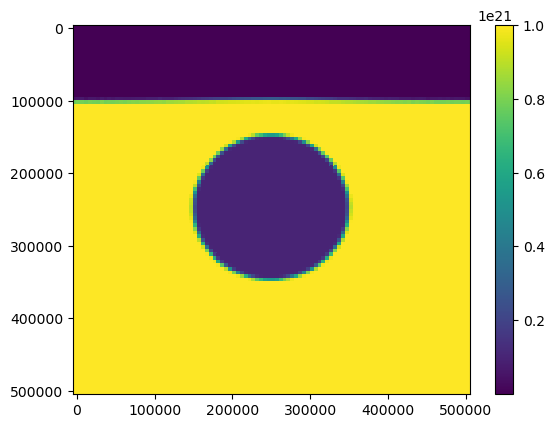

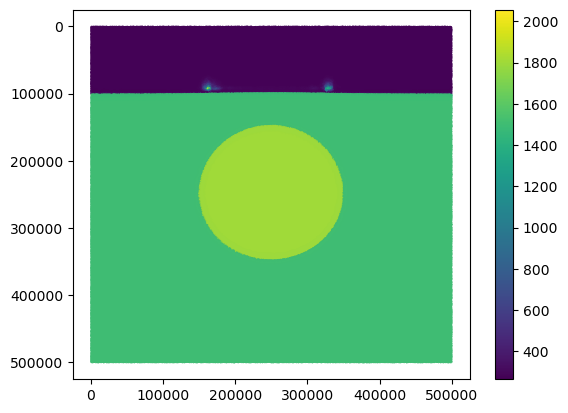

In [13]:
figure()
title(print(time/3.15e7))
pcolor(grid.xc,grid.yc,eta_n)
gca().invert_yaxis()
colorbar()
show()

figure()
scatter(markers.x[1,:],markers.x[2,:],c=markers.scalars[markers.scalarFields["T"],:],s=0.1)
gca().invert_yaxis()
colorbar()
show()

Creating Markers...
  0.004955 seconds (19 allocations: 28.154 MiB)
Initial condition...
  0.084718 seconds (1.08 M allocations: 17.151 MiB)
Trying with timestep 0.020757417339307506 Myr
dTmax=8.707019489023367 dt=0.020757417339307506
Writing visualization fle test/viz.0000.vtr
Min/Max velocity: -3.8234563610564795e-9 2.227291865781608e-9
Finished Step 1 time=0.020757417339307506 Myr
Trying with timestep 0.0006427955616267003 Myr
dTmax=9.065776305956717 dt=0.0006427955616267003
Min/Max velocity: -1.1171747506995375e-7 1.2346861755584144e-7
Finished Step 2 time=0.02140021290093421 Myr
Trying with timestep 0.0007713546739520404 Myr
dTmax=7.504305972531768 dt=0.0007713546739520404
Min/Max velocity: -5.833321917987856e-9 8.674612856575528e-9
Finished Step 3 time=0.02217156757488625 Myr
Trying with timestep 0.0009256256087424483 Myr
dTmax=6.315026794552807 dt=0.0009256256087424483
Min/Max velocity: -5.8009100336588555e-9 8.391436379243685e-9
Finished Step 4 time=0.023097193183628698 Myr
Try

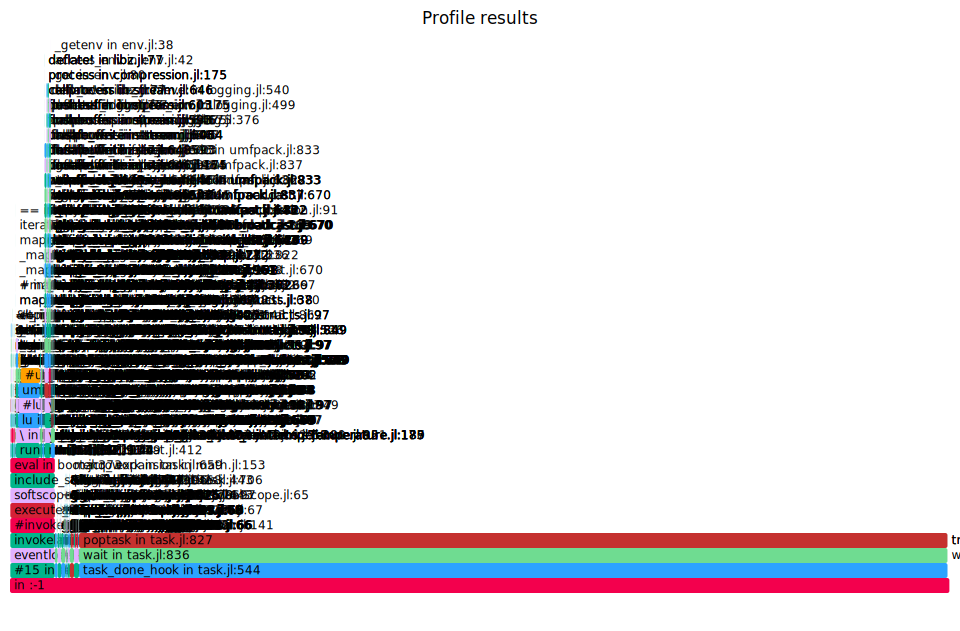

In [14]:
using ProfileSVG
@profview run(10)

In [9]:
maximum(markers.x[2,:])

499342.97275490186

In [7]:
any(isnan.(vxc))

false